<a href="https://colab.research.google.com/github/ndb796/AI-Implementations-for-All/blob/master/Neural%20Style%20Transfer/Neural_Style_Transfer_(Basic).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 소스코드를 실행하기 전에 **[런타임]** - **[런타임 유형 변경]** - **[GPU]**로 설정되어 있는지 확인합니다.
* 정사각형에 가까운 두 이미지를 준비합니다. (1 x 1 해상도로 자동 변경됩니다.)

In [0]:
# 필요한 라이브러리를 모두 불러옵니다.
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [0]:
# GPU 디바이스 객체를 초기화합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 결과 이미지의 크기를 설정합니다.
imsize = 512

# 이미지를 모델에 넣을 수 있는 텐서(Tensor) 자료형으로 변환하는 기능
loader = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor()])
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# 텐서(Tensor) 자료형으로 변환된 이미지를 다시 출력할 수 있도록 하는 기능
unloader = transforms.ToPILImage()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

* 이미지 파일을 업로드합니다.
* 두 이미지의 크기가 달라도 상관 없습니다.
* 가능하면 두 이미지 모두 **정사각형 형태(1 x 1)**의 이미지가 될 수 있도록 준비합니다.

In [0]:
# 콘텐츠(Content) 이미지와 스타일(Style) 이미지를 모두 업로드합니다.
from google.colab import files

uploaded = files.upload()

In [0]:
# 자신이 업로드한 이미지 파일명과 동일한지 확인합니다. (확장자명에 유의하세요.)
content_img = image_loader("dog.jpg")
style_img = image_loader("blocks.jpg")

assert style_img.size() == content_img.size(), "변환된 두 이미지의 크기는 같아야 합니다."

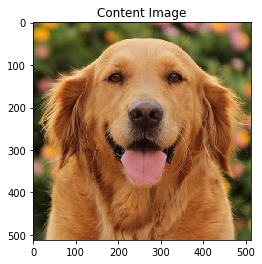

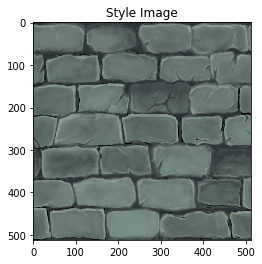

In [0]:
# 콘텐츠(Content) 이미지와 스타일(Style) 이미지를 차례대로 화면에 출력합니다.
plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(style_img, title='Style Image')

In [0]:
# 콘텐츠(Content) 비용 함수를 정의합니다.
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

# 스타일(Style) 비용 함수를 정의합니다.
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [0]:
# 뉴럴 네트워크 모델을 불러옵니다.
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [0]:
# 정규화(Normalization)을 위한 초기화
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [0]:
# 비용을 계산할 때 사용할 레이어를 정의합니다.
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# 전체적인 비용(Loss)을 계산하는 함수를 정의합니다.
def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, style_losses, content_losses

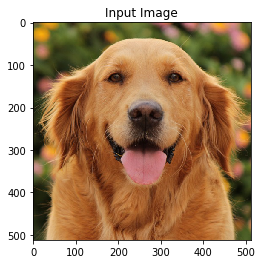

In [0]:
# 최적화를 진행할 시작 이미지를 설정합니다.
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
# 실질적으로 Neural Style Transfer를 진행하는 함수를 정의합니다.
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):

    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

run [50]:
Style Loss : 26.391455 Content Loss: 9.211019

run [100]:
Style Loss : 2.745670 Content Loss: 6.682399

run [150]:
Style Loss : 1.463525 Content Loss: 5.453017

run [200]:
Style Loss : 1.048137 Content Loss: 4.939741

run [250]:
Style Loss : 0.773685 Content Loss: 4.688909

run [300]:
Style Loss : 0.609969 Content Loss: 4.535065



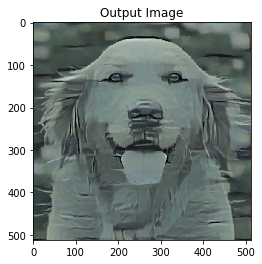

In [0]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

imshow(output, title='Output Image')
plt.show()

In [0]:
import cv2 

# 만들어진 결과물을 이미지 파일 형태로 저장합니다.
def image_reshape(image):
  image = image.permute(1, 2, 0)
  return image

reshaped_image = image_reshape(output.cpu().detach()[0]).numpy()
cv2.imwrite('output.jpg', reshaped_image * 255)
print('이미지 파일 저장을 완료했습니다.')

이미지 파일 저장을 완료했습니다.


In [0]:
# 완성된 이미지를 다운로드합니다.
files.download('output.jpg')